# Explanatory Anomaly Detection on Nuscenes data

This system demos the reasonableness monitoring system and anomaly detection through explanations on the Nuscenes dataset.  This code assumes that the database is available at `../data/`, but this can be changed to the directory where the dataset is located.  

This is processing on the mini version of the full dataset.  The full dataset processing will soon follow.  

In [1]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
import pprint as pp
from nuscenes.utils.data_classes import *

# TODO: this should be changed somewhere 
data_root = '/Users/leilani/Dropbox (MIT)/car-can-explain/data/'
nuscenes_root = data_root+'nuscenes-data/'
data_name = 'v1.0-mini'

nusc = NuScenes(version=data_name, dataroot=nuscenes_root+data_name, verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.6 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.


In [2]:
nusc.list_scenes()

scene-0061, Parked truck, construction, intersectio... [18-07-24 03:28:47]   19s, singapore-onenorth, #anns:4622
scene-0103, Many peds right, wait for turning car, ... [18-08-01 19:26:43]   19s, boston-seaport, #anns:2046
scene-0655, Parking lot, parked cars, jaywalker, be... [18-08-27 15:51:32]   20s, boston-seaport, #anns:2332
scene-0553, Wait at intersection, bicycle, large tr... [18-08-28 20:48:16]   20s, boston-seaport, #anns:1950
scene-0757, Arrive at busy intersection, bus, wait ... [18-08-30 19:25:08]   20s, boston-seaport, #anns:592
scene-0796, Scooter, peds on sidewalk, bus, cars, t... [18-10-02 02:52:24]   20s, singapore-queensto, #anns:708
scene-0916, Parking lot, bicycle rack, parked bicyc... [18-10-08 07:37:13]   20s, singapore-queensto, #anns:2387
scene-1077, Night, big street, bus stop, high speed... [18-11-21 11:39:27]   20s, singapore-hollandv, #anns:890
scene-1094, Night, after rain, many peds, PMD, ped ... [18-11-21 11:47:27]   19s, singapore-hollandv, #anns:1762
sc

# LiDAR description: Proof of concept

Start with one scene at a time. Qualitatively describe LiDAR.   

In [3]:
my_scene = nusc.scene[0]
my_scene

#nusc.ego_pose[my_s]

{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

In [4]:
SENSOR = 'LIDAR_TOP'

my_sample_token = my_scene['first_sample_token']
my_sample = nusc.get('sample', my_sample_token)

sensor_data = nusc.get('sample_data', my_sample['data'][SENSOR])
sample_offset = nusc.get('calibrated_sensor', sensor_data['calibrated_sensor_token'])['translation']

def sample_summary(sample):
    print("%d annotations in this sample"%len(sample['anns']))

sample_offset
offset = np.array(sample_offset)

In [6]:
SENSOR = 'LIDAR_TOP'
RING_IND = 4 # It's the fourth element
INTENSITY_IND = 3
import numpy as np
from nuscenes.utils.data_classes import LidarPointCloud

def get_raw_lidar(sample):
    """
    Loads LIDAR data from binary numpy format. Data is stored as (x, y, z, intensity, ring index).
    """
    lidar_data = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
    file_path = nuscenes_root+data_name+'/'+lidar_data['filename']
    scan = np.fromfile(file_path, dtype=np.float32)
    return scan

def with_ring(sample):
    """
    Retuns (x, y, z, intensity, ring index).
    """
    scan = get_raw_lidar(sample)
    points = scan.reshape((-1,5))
    print(np.shape(points))
    return points

def get_lidar_points(sample):
    """
    Some reshaping
    """
    scan = get_raw_lidar(sample)
    #scan = np.fromfile(file_name, dtype=np.float32)
    points = scan.reshape((-1, 5))[:, :4]
    return points.T

def get_point_cloud(sample):
    """
    LidarPointCloud instance (x, y, z, intensity).
    """
    lidar_data = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
    file_path = nuscenes_root+data_name+'/'+lidar_data['filename']
    print(file_path)
    points = LidarPointCloud.from_file(file_path)
    # print(size(points))

# 34688/1084 = 32 rings?

raw = get_raw_lidar(my_sample)
points = get_lidar_points(my_sample)
rings = with_ring(my_sample)

hits = rings[rings[:,INTENSITY_IND]>0]
print(np.size(rings))
print(np.size(hits))
# by_intensity = rings[rings[:,INTENSITY_IND].argsort()[::-1]]

# for x in range(0,5):
#     print(by_intensity[x])
# Hypothesis the radius of each ring should be the same. 

def radius(point, center=offset):
    """
    This works because Euclidean distance is l2 norm 
    and the default value of ord parameter in numpy.linalg.norm is 2.
    """
    return np.linalg.norm(center-point)

# filter_one = rings[rings[:,RING_IND]==6]
filter_ten = rings[rings[:,RING_IND]==10]
filter_twenty = rings[rings[:,RING_IND]==20]

no_hits = rings[rings[:,INTENSITY_IND]==0]
print("No hits",np.shape(no_hits))

filter_zero = rings[rings[:,RING_IND]==0]

filter_eight = rings[rings[:,RING_IND]==8]

last = filter_one[0][0::2]
for point in filter_one:
    current = point[0::2]
    #print(radius(current))
    #print(current-last)
    #print(radius(current,last))
    last = current

# for point in rings:
#     #print(type(point))
#     print(point.round(2))
# # print(filter_one)

# file1 = open("ring0.txt","a")
# file1.writeLines(filter)

# Program to show various ways to read and 
# write data in a file. 
# file1 = open("myfile.txt","w") 
# L = ["This is Delhi \n","This is Paris \n","This is London \n"]  
  
# # \n is placed to indicate EOL (End of Line) 
# file1.write("Hello \n") 
# file1.writelines(L) 

file8 = open("ring8_v2.txt","a")
for line in filter_eight:
    [x,y,z,ring,_] =line
    file8.write("%f %f %f %f\n"%(x,y,z,ring))
file8.close()
# file8.writeLines(filter8)
#for line in filter_eight:


def write_ring_to_file(ring):
    fileName = "ring_%d.txt"%ring
    file = open(fileName,"w")
    filtered = rings[rings[:,RING_IND]==ring]

    for line in filtered:
        [x,y,z,ring,_] =line
        file.write("%f %f %f %f\n"%(x,y,z,ring))
    file.close()
                
write_ring_to_file(8)


(34688, 5)
173440
173235
No hits (41, 5)


NameError: name 'filter_one' is not defined

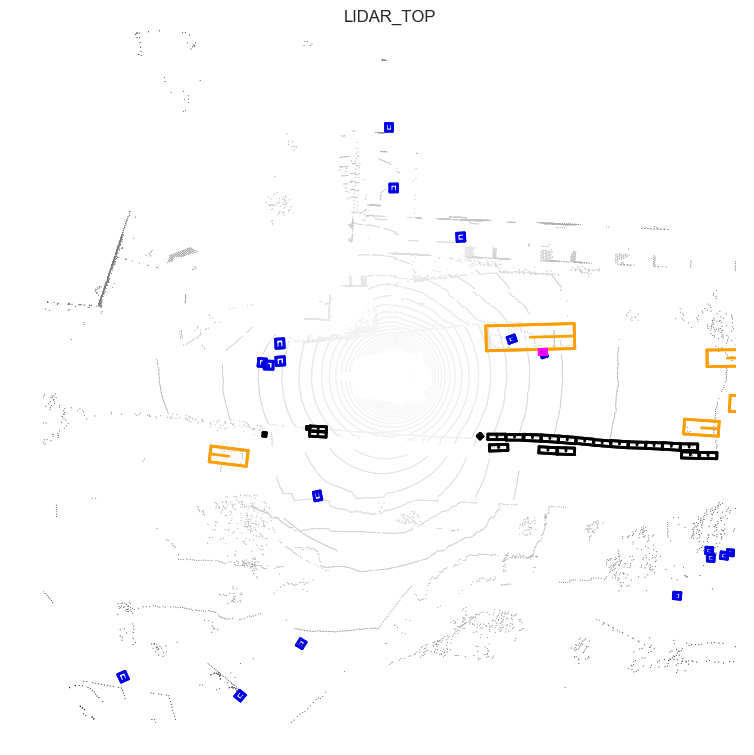

In [80]:
def display_lidar_sample(sample, sweeps=5, map=False):
    nusc.render_sample_data(sample['data']['LIDAR_TOP'], nsweeps=5,
                            underlay_map=map)
display_lidar_sample(my_sample)

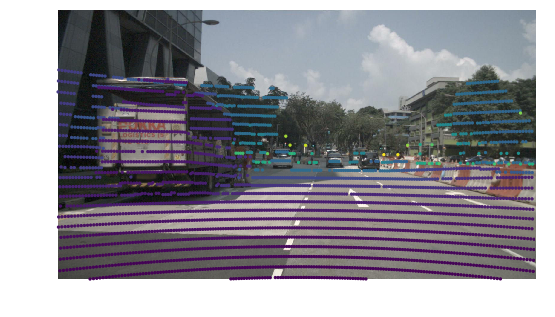

In [7]:
# my_sample = nusc.sample[10]
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_TOP')

In [8]:
from nuscenes.utils.geometry_utils import points_in_box

point_cloud = get_point_cloud(my_sample)

for ann_token in my_sample['anns']:
    annotation = nusc.get('sample_annotation', ann_token)
    center = annotation['translation']
    size = annotation['size']
    orientation = Quaternion(annotation['rotation'])
    
    ann_box = Box(center, size, orientation)
    mask = points_in_box(ann_box,point_cloud)
    print(mask)
    #print(annotation)
# points_in_box(box: 'Box', points: np.ndarray

TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

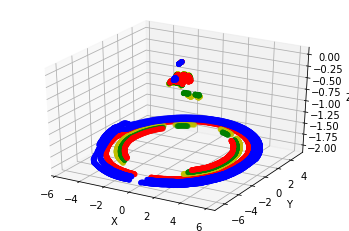

In [26]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

[dx,dy,dz] = [0,0,0]


temp = rings[rings[:,RING_IND]==4]
x = temp[:,0]-dx
y = temp[:,1]-dy
z = temp[:,2]-dz

temp2 = rings[rings[:,RING_IND]==5]
x2 = temp2[:,0]-dx
y2 = temp2[:,1]-dy
z2 = temp2[:,2]-dz

temp = rings[rings[:,RING_IND]==6]
x6 = temp[:,0]-dx
y6 = temp[:,1]-dy
z6 = temp[:,2]-dz

temp8 = rings[rings[:,RING_IND]==8]
x8 = temp8[:,0]-dx
y8 = temp8[:,1]-dy
z8 = temp8[:,2]-dz

temp9 = rings[rings[:,RING_IND]==9]
x9 = temp9[:,0]-dx
y9 = temp9[:,1]-dy
z9 = temp9[:,2]-dz

temp3 = rings[rings[:,RING_IND]==10]
x3 = temp3[:,0]-dx
y3 = temp3[:,1]-dy
z3 = temp3[:,2]-dz

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# x =[1,2,3,4,5,6,7,8,9,10]
# y =[5,6,2,3,13,4,1,2,4,8]
# z =[2,3,3,3,5,7,9,11,9,10]

ax.scatter(x, y, z, c='r', marker='o')
ax.scatter(x2, y2, z2, c='g', marker='o')
ax.scatter(x3, y3, z3, c='b', marker='o')
ax.scatter(x6, y6, z6, c='y', marker='o')
# ax.scatter(x8, y8, z8, c='r', marker='o')
# ax.scatter(x9, y9, z9, c='b', marker='o')

plt.show()

(34688, 5)


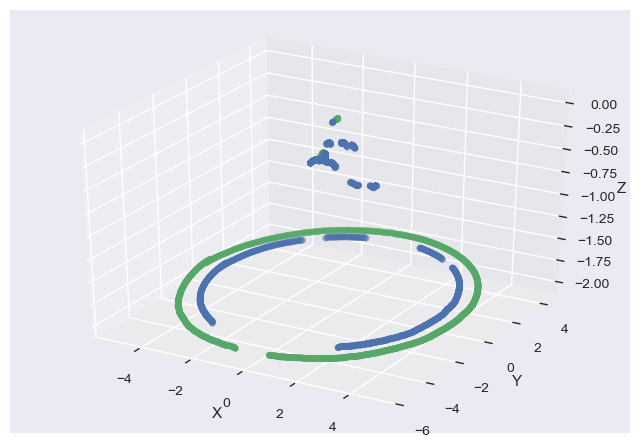

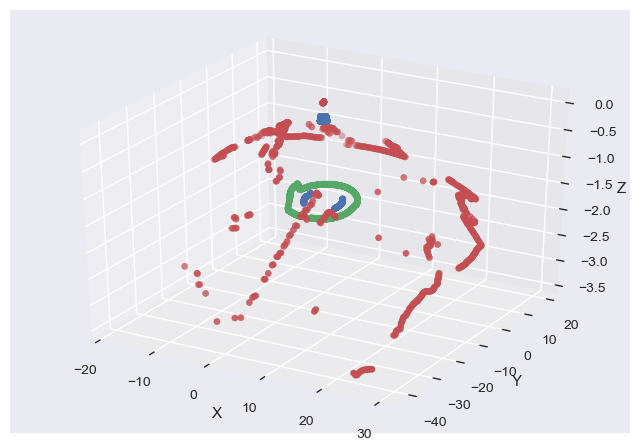

In [86]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

rings = with_ring(my_sample)

def visualize_rings(rings, ring_nums):
    """
    takes in the rings and the ring numbers
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    for ring in ring_nums:
        temp = rings[rings[:,RING_IND]==ring]
        x = temp[:,0]
        y = temp[:,1]
        z = temp[:,2]

        ax.scatter(x,y,z, marker='o')
    plt.show()

# blue
# green
# red
visualize_rings(rings, [6,8])
visualize_rings(rings, [1,10,20])
    

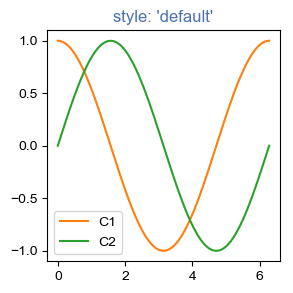

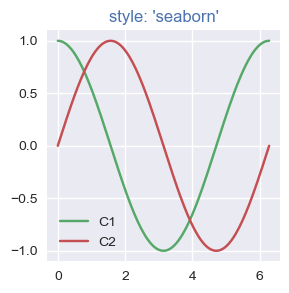

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

th = np.linspace(0, 2*np.pi, 128)


def demo(sty):
    mpl.style.use(sty)
    fig, ax = plt.subplots(figsize=(3, 3))

    ax.set_title('style: {!r}'.format(sty), color='C0')

    ax.plot(th, np.cos(th), 'C1', label='C1')
    ax.plot(th, np.sin(th), 'C2', label='C2')
    ax.legend()

demo('default')
demo('seaborn')

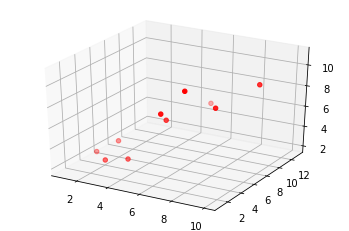

In [108]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x =[1,2,3,4,5,6,7,8,9,10]
y =[5,6,2,3,13,4,1,2,4,8]
z =[2,3,3,3,5,7,9,11,9,10]



ax.scatter(x, y, z, c='r', marker='o')

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

plt.show()

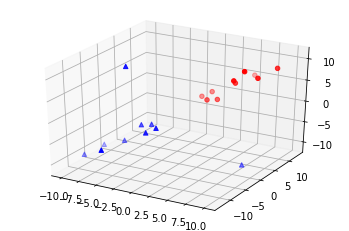

In [48]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs =[1,2,3,4,5,6,7,8,9,10]
ys =[5,6,2,3,13,4,1,2,4,8]
zs =[2,3,3,3,5,7,9,11,9,10]

xt =[-1,-2,-3,-4,-5,-6,-7,8,-9,-10]
yt =[-5,-6,-2,-3,-13,-4,-1,2,-4,-8]
zt =[-2,-3,-3,-3,-5,-7,9,-11,-9,-10]

ax.scatter(xs, ys, zs, c='r', marker='o')
ax.scatter(xt, yt, zt, c='b', marker='^')

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

plt.show()

In [9]:
first_scene = nusc.scene[0]
fourth_scene = nusc.scene[4]
first_scene

def get_description(scene):
    """
    Returns a list of the descriptions of a particular scene
    Underscores make it easier to query the commonsense knowledge base
    """
    text_description = scene['description']
    descriptions = text_description.split(',')
    description_list = []
    for label in descriptions:
        # for conceptNet debugging
        description_list.append(label.strip().replace(' ', '_').lower())
    return description_list

print(get_description(first_scene))
print(get_description(fourth_scene))

['parked_truck', 'construction', 'intersection', 'turn_left', 'following_a_van']
['arrive_at_busy_intersection', 'bus', 'wait_at_intersection', 'bicycle', 'peds']


In [22]:
my_sample_token = my_scene['first_sample_token']
my_sample = nusc.get('sample', my_sample_token)

ann = my_sample['anns'][0]
first_ann = nusc.get('sample_annotation', ann)
first_ann

{'token': 'ef63a697930c4b20a6b9791f423351da',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'instance_token': '6dd2cbf4c24b4caeb625035869bca7b5',
 'visibility_token': '1',
 'attribute_tokens': ['4d8821270b4a47e3a8a300cbec48188e'],
 'translation': [373.256, 1130.419, 0.8],
 'size': [0.621, 0.669, 1.642],
 'rotation': [0.9831098797903927, 0.0, 0.0, -0.18301629506281616],
 'prev': '',
 'next': '7987617983634b119e383d8a29607fd7',
 'num_lidar_pts': 1,
 'num_radar_pts': 0,
 'category_name': 'human.pedestrian.adult'}

### Nuscenes Analysis and Testing

In [12]:
import datetime
NORMALIZE = 1000000.0

def iterate_scenes(limit=1, debug=False):
    """
    This will go through all the scenes in a particular dataset.
    Currently limit is set to 1 for testing.
    
    Assumes that scenes are independent (instances are not tracked across scenes)
    """
    for index in range(0,limit):
        if debug:
            print("Processing Scene %d"%index)
        explain_scene(nusc.scene[index], debug)

def explain_scene(scene, debug=False):
    raw_data = {}
    first_token = scene['first_sample_token']
    frame = nusc.get('sample', first_token)
    time = convert_time(frame['timestamp'])
    sizes = []
    
    frame_tokens = [first_token]
    
    while frame['next']: # is not None:
        token = frame['next']
        #print("getting data for %s"%token)
        frame = nusc.get('sample', token)
        populate_frame_data(frame, time, raw_data, sizes, debug) # This updates the raw_data 
        time = convert_time(frame['timestamp'])
        frame_tokens.append(token)
    #print("Finished explaining scene at time=%d seconds with %s"%(time, scene['token'], scene['description']))
    if debug:
        print("Finished explaining scene at %s with %s"%(time, scene['description']))
        print("Summary of explanations at scene level with %d distinct annotations"%len(raw_data))

def populate_frame_data(frame, time, raw_data, sizes, debug=False):
    """
    Go through all the annotations for a particular frame
    """
    if debug:
        print("Frame at %s has %d labeled objects" %( convert_time(frame['timestamp']), len(frame['anns'])))
    
    #raw_data = {}
    for ann_token in frame['anns']:
        ann_data = nusc.get('sample_annotation', ann_token)
        instance = ann_data['instance_token']
        # Need category, size, translation
        # Might also what to store keys
        # Split into LiDAR and Vision 
        
        # token, sample_token, instance_token, visibility_token, if attribute_tokens
        # translation, size, prev and next --> Which ones are they referring to
        frame_explanation = monitor_frame(ann_data, sizes)
        results = (ann_data, frame_explanation)
        if instance not in raw_data:
            raw_data[instance] = [results]
        else:
            raw_data[instance].append(results)
        #raw_data.append([ann_data['category_name'], ann_data['visibility_token'], ann_data['translation'], ann_data['size']])
    #print(raw_data)
    #track_annotation(ann_data['instance_token'], ann_data['next'])

keys = ['visibility_token', 'size', 'translation', 'category_name']
    
def monitor_frame(ann_data, size):
    #print(ann_data)
    #print({k:d[k] for k in l if k in d})
    #print({k:ann_data[k] for k in ann_data if k in keys})
    # Convert translation / size to feet and take away ego pose.
    return

def track_annotation(instance_token, next_token):
    instance = nusc.get('instance', instance_token)
    #print(instance)
    annotation = nusc.get('sample_annotation', next_token)
    #print("In tracking and annotation is %s" %annotation)
    describe(annotation, nusc.get('sample', annotation['sample_token']))
    
    while not annotation['next'] == '':
        next_annotation = nusc.get('sample_annotation', annotation['next'])
        # print(next_annotation)
        annotation = next_annotation
        describe(annotation, nusc.get('sample', annotation['sample_token']))
    print("Done processing annotation")
    return

def convert_time(unix_time):
    return datetime.datetime.fromtimestamp(unix_time/NORMALIZE)

def describe(annotation, sample):
    print("%s found at time %s"%(annotation['category_name'], convert_time(sample['timestamp'])))

explain_scene(first_scene, True) # Debugging is on for now

Frame at 2018-07-23 23:28:48.147847 has 78 labeled objects
Frame at 2018-07-23 23:28:48.698048 has 86 labeled objects
Frame at 2018-07-23 23:28:49.197353 has 94 labeled objects
Frame at 2018-07-23 23:28:49.697797 has 103 labeled objects
Frame at 2018-07-23 23:28:50.152601 has 103 labeled objects
Frame at 2018-07-23 23:28:50.648325 has 110 labeled objects
Frame at 2018-07-23 23:28:51.198511 has 118 labeled objects
Frame at 2018-07-23 23:28:51.697833 has 120 labeled objects
Frame at 2018-07-23 23:28:52.197715 has 124 labeled objects
Frame at 2018-07-23 23:28:52.647284 has 127 labeled objects
Frame at 2018-07-23 23:28:53.146604 has 129 labeled objects
Frame at 2018-07-23 23:28:53.646462 has 136 labeled objects
Frame at 2018-07-23 23:28:54.146351 has 137 labeled objects
Frame at 2018-07-23 23:28:54.696555 has 141 labeled objects
Frame at 2018-07-23 23:28:55.197541 has 143 labeled objects
Frame at 2018-07-23 23:28:55.697945 has 147 labeled objects
Frame at 2018-07-23 23:28:56.198962 has 148

We generally track an instance across different frames in a particular scene. However, we do not track them across different scenes. In this example, we have 16 annotated samples for this instance across a particular scene.

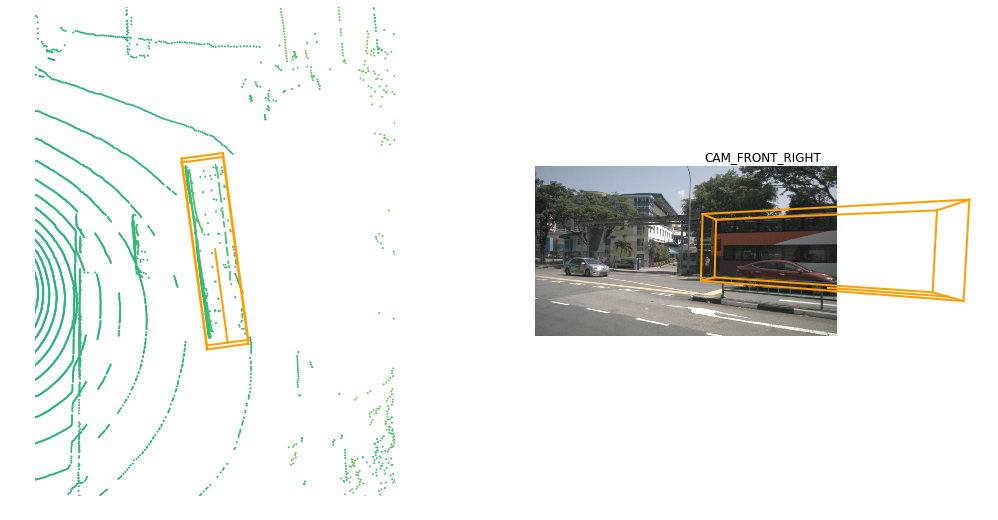

In [16]:
instance_token = my_instance['token']
nusc.render_instance(instance_token)

An instance record takes note of its first and last annotation token. Let's render them

First annotated sample of this instance:


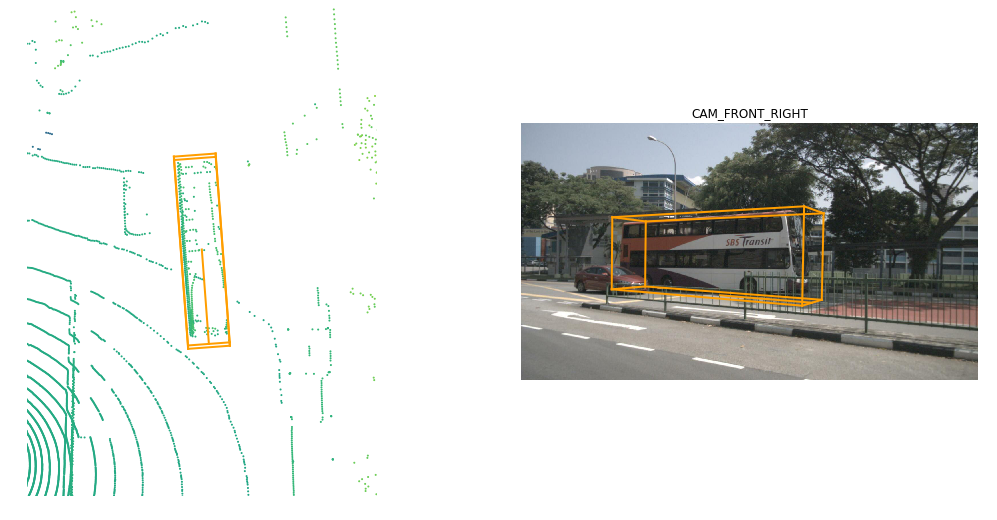

In [17]:
print("First annotated sample of this instance:")
nusc.render_annotation(my_instance['first_annotation_token'])

Last annotated sample of this instance


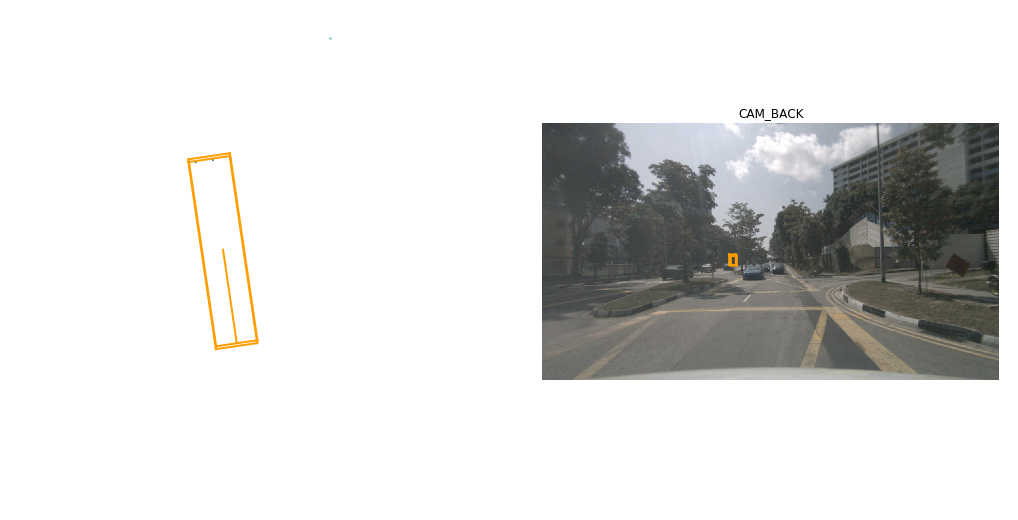

In [18]:
print("Last annotated sample of this instance")
nusc.render_annotation(my_instance['last_annotation_token'])

`visibility` is defined as the fraction of pixels of a particular annotation that are visible over the 6 camera feeds, grouped into 4 bins.

In [23]:
nusc.visibility

[{'description': 'visibility of whole object is between 0 and 40%',
  'token': '1',
  'level': 'v0-40'},
 {'description': 'visibility of whole object is between 40 and 60%',
  'token': '2',
  'level': 'v40-60'},
 {'description': 'visibility of whole object is between 60 and 80%',
  'token': '3',
  'level': 'v60-80'},
 {'description': 'visibility of whole object is between 80 and 100%',
  'token': '4',
  'level': 'v80-100'}]

Let's look at an example `sample_annotation` with 80-100% visibility

Visibility: {'description': 'visibility of whole object is between 80 and 100%', 'token': '4', 'level': 'v80-100'}


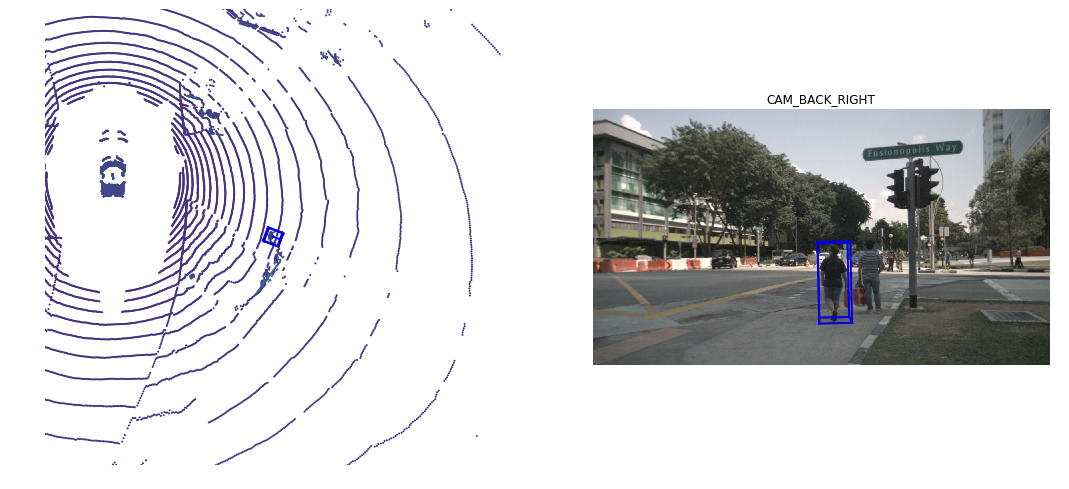

In [24]:
anntoken = 'a7d0722bce164f88adf03ada491ea0ba'
visibility_token = nusc.get('sample_annotation', anntoken)['visibility_token']

print("Visibility: {}".format(nusc.get('visibility', visibility_token)))
nusc.render_annotation(anntoken)

Let's look at an example `sample_annotation` with 0-40% visibility

Visibility: {'description': 'visibility of whole object is between 0 and 40%', 'token': '1', 'level': 'v0-40'}


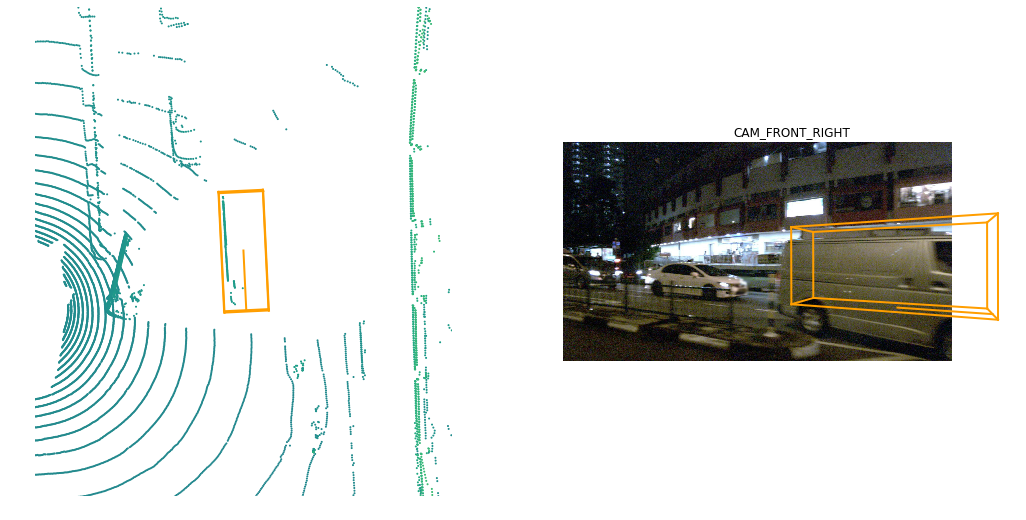

In [25]:
anntoken = '9f450bf6b7454551bbbc9a4c6e74ef2e'
visibility_token = nusc.get('sample_annotation', anntoken)['visibility_token']

print("Visibility: {}".format(nusc.get('visibility', visibility_token)))
nusc.render_annotation(anntoken)

### 9. `sensor`

The nuScenes dataset consists of data collected from our full sensor suite which consists of:
- 1 x LIDAR, 
- 5 x RADAR, 
- 6 x cameras, 

In [26]:
nusc.sensor

[{'token': '725903f5b62f56118f4094b46a4470d8',
  'channel': 'CAM_FRONT',
  'modality': 'camera'},
 {'token': 'ce89d4f3050b5892b33b3d328c5e82a3',
  'channel': 'CAM_BACK',
  'modality': 'camera'},
 {'token': 'a89643a5de885c6486df2232dc954da2',
  'channel': 'CAM_BACK_LEFT',
  'modality': 'camera'},
 {'token': 'ec4b5d41840a509984f7ec36419d4c09',
  'channel': 'CAM_FRONT_LEFT',
  'modality': 'camera'},
 {'token': '2f7ad058f1ac5557bf321c7543758f43',
  'channel': 'CAM_FRONT_RIGHT',
  'modality': 'camera'},
 {'token': 'ca7dba2ec9f95951bbe67246f7f2c3f7',
  'channel': 'CAM_BACK_RIGHT',
  'modality': 'camera'},
 {'token': 'dc8b396651c05aedbb9cdaae573bb567',
  'channel': 'LIDAR_TOP',
  'modality': 'lidar'},
 {'token': '47fcd48f71d75e0da5c8c1704a9bfe0a',
  'channel': 'RADAR_FRONT',
  'modality': 'radar'},
 {'token': '232a6c4dc628532e81de1c57120876e9',
  'channel': 'RADAR_FRONT_RIGHT',
  'modality': 'radar'},
 {'token': '1f69f87a4e175e5ba1d03e2e6d9bcd27',
  'channel': 'RADAR_FRONT_LEFT',
  'modality'

Every `sample_data` has a record on which `sensor` the data is collected from (note the "channel" key)

In [27]:
nusc.sample_data[10]

{'token': '2ecfec536d984fb491098c9db1404117',
 'sample_token': '356d81f38dd9473ba590f39e266f54e5',
 'ego_pose_token': '2ecfec536d984fb491098c9db1404117',
 'calibrated_sensor_token': 'f4d2a6c281f34a7eb8bb033d82321f79',
 'timestamp': 1532402928269133,
 'fileformat': 'pcd',
 'is_key_frame': False,
 'height': 0,
 'width': 0,
 'filename': 'sweeps/RADAR_FRONT/n015-2018-07-24-11-22-45+0800__RADAR_FRONT__1532402928269133.pcd',
 'prev': 'b933bbcb4ee84a7eae16e567301e1df2',
 'next': '79ef24d1eba84f5abaeaf76655ef1036',
 'sensor_modality': 'radar',
 'channel': 'RADAR_FRONT'}

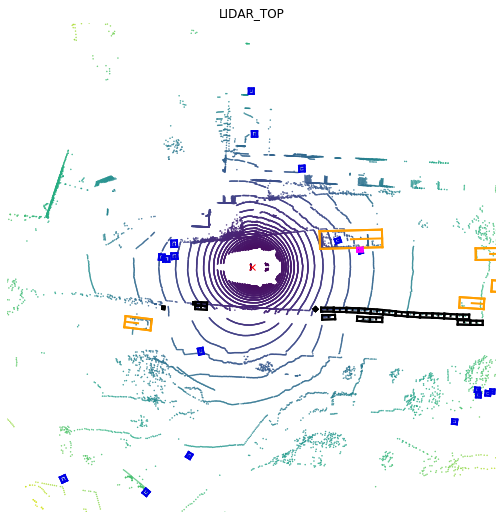

In [77]:
def display_lidar_sample(sample, sweeps=5):
    nusc.render_sample_data(sample['data']['LIDAR_TOP'], nsweeps=1,
                            underlay_map=False)
display_lidar_sample(first_sample, 1)

def get_lidar_points(sample):
    lidar_data = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
    file_path = nuscenes_root+data_name+'/'+lidar_data['filename']
    points = LidarPointCloud.from_file(file_path)
    return points

### 10. `calibrated_sensor`

`calibrated_sensor` consists of the definition of a particular sensor (lidar/radar/camera) as calibrated on a particular vehicle. Let us look at an example.

In [28]:
nusc.calibrated_sensor[0]

{'token': 'f4d2a6c281f34a7eb8bb033d82321f79',
 'sensor_token': '47fcd48f71d75e0da5c8c1704a9bfe0a',
 'translation': [3.412, 0.0, 0.5],
 'rotation': [0.9999984769132877, 0.0, 0.0, 0.0017453283658983088],
 'camera_intrinsic': []}

Note that the `translation` and the `rotation` parameters are given with respect to the ego vehicle body frame. 

### 11. `ego_pose`

`ego_pose` contains information about the location (encoded in `translation`) and the orientation (encoded in `rotation`) of the ego vehicle body frame, with respect to the global coordinate system.

In [29]:
nusc.ego_pose[0]

{'token': '5ace90b379af485b9dcb1584b01e7212',
 'timestamp': 1532402927814384,
 'rotation': [0.5731787718287827,
  -0.0015811634307974854,
  0.013859363182046986,
  -0.8193116095230444],
 'translation': [410.77878632230204, 1179.4673290964536, 0.0]}

Note that the number of `ego_pose` records in our loaded database is the same as the number of `sample_data` records. These two records exhibit a one-to-one correspondence.

### 12. `log`

The `log` table contains log information from which the data was extracted. A `log` record corresponds to one journey of our ego vehicle along a predefined route. Let's check the number of logs and the metadata of a log.

In [30]:
print("Number of `logs` in our loaded database: {}".format(len(nusc.log)))

Number of `logs` in our loaded database: 8


In [31]:
nusc.log[0]

{'token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'logfile': 'n015-2018-07-24-11-22-45+0800',
 'vehicle': 'n015',
 'date_captured': '2018-07-24',
 'location': 'singapore-onenorth',
 'map_token': '53992ee3023e5494b90c316c183be829'}

Notice that it contains a variety of information such as the date and location of the log collected. It also gives out information about the map from where the data was collected. Note that one log can contain multiple non-overlapping scenes.

### 13. `map`

Map information is stored as binary semantic masks from a top-down view. Let's check the number of maps and metadata of a map.

In [32]:
print("There are {} maps masks in the loaded dataset".format(len(nusc.map)))

There are 4 maps masks in the loaded dataset


In [33]:
nusc.map[0]

{'category': 'semantic_prior',
 'token': '53992ee3023e5494b90c316c183be829',
 'filename': 'maps/53992ee3023e5494b90c316c183be829.png',
 'log_tokens': ['0986cb758b1d43fdaa051ab23d45582b',
  '1c9b302455ff44a9a290c372b31aa3ce',
  'e60234ec7c324789ac7c8441a5e49731',
  '46123a03f41e4657adc82ed9ddbe0ba2',
  'a5bb7f9dd1884f1ea0de299caefe7ef4',
  'bc41a49366734ebf978d6a71981537dc',
  'f8699afb7a2247e38549e4d250b4581b',
  'd0450edaed4a46f898403f45fa9e5f0d',
  'f38ef5a1e9c941aabb2155768670b92a',
  '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
  'ddc03471df3e4c9bb9663629a4097743',
  '31e9939f05c1485b88a8f68ad2cf9fa4',
  '783683d957054175bda1b326453a13f4',
  '343d984344e440c7952d1e403b572b2a',
  '92af2609d31445e5a71b2d895376fed6',
  '47620afea3c443f6a761e885273cb531',
  'd31dc715d1c34b99bd5afb0e3aea26ed',
  '34d0574ea8f340179c82162c6ac069bc',
  'd7fd2bb9696d43af901326664e42340b',
  'b5622d4dcb0d4549b813b3ffb96fbdc9',
  'da04ae0b72024818a6219d8dd138ea4b',
  '6b6513e6c8384cec88775cae30b78c0e',
  'eda311bda86f

## nuScenes Basics

Let's get a bit technical.

The NuScenes class holds several tables. Each table is a list of records, and each record is a dictionary. For example the first record of the category table is stored at:

In [34]:
nusc.category[0]

{'token': '1fa93b757fc74fb197cdd60001ad8abf',
 'name': 'human.pedestrian.adult',
 'description': 'Adult subcategory.'}

The category table is simple: it holds the fields `name` and `description`. It also has a `token` field, which is a unique record identifier. Since the record is a dictionary, the token can be accessed like so:

In [35]:
cat_token = nusc.category[0]['token']
cat_token

'1fa93b757fc74fb197cdd60001ad8abf'

If you know the `token` for any record in the DB you can retrieve the record by doing

In [36]:
nusc.get('category', cat_token)

{'token': '1fa93b757fc74fb197cdd60001ad8abf',
 'name': 'human.pedestrian.adult',
 'description': 'Adult subcategory.'}

_As you can notice, we have recovered the same record!_

OK, that was easy. Let's try something harder. Let's look at the `sample_annotation` table.

In [37]:
nusc.sample_annotation[0]

{'token': '70aecbe9b64f4722ab3c230391a3beb8',
 'sample_token': 'cd21dbfc3bd749c7b10a5c42562e0c42',
 'instance_token': '6dd2cbf4c24b4caeb625035869bca7b5',
 'visibility_token': '4',
 'attribute_tokens': ['4d8821270b4a47e3a8a300cbec48188e'],
 'translation': [373.214, 1130.48, 1.25],
 'size': [0.621, 0.669, 1.642],
 'rotation': [0.9831098797903927, 0.0, 0.0, -0.18301629506281616],
 'prev': 'a1721876c0944cdd92ebc3c75d55d693',
 'next': '1e8e35d365a441a18dd5503a0ee1c208',
 'num_lidar_pts': 5,
 'num_radar_pts': 0,
 'category_name': 'human.pedestrian.adult'}

This also has a `token` field (they all do). In addition, it has several fields of the format [a-z]*\_token, _e.g._ instance_token. These are foreign keys in database terminology, meaning they point to another table. 
Using `nusc.get()` we can grab any of these in constant time. For example, let's look at the visibility record.

In [38]:
nusc.get('visibility', nusc.sample_annotation[0]['visibility_token'])

{'description': 'visibility of whole object is between 80 and 100%',
 'token': '4',
 'level': 'v80-100'}

The visibility records indicate how much of an object was visible when it was annotated.

Let's also grab the `instance_token`

In [39]:
one_instance = nusc.get('instance', nusc.sample_annotation[0]['instance_token'])
one_instance

{'token': '6dd2cbf4c24b4caeb625035869bca7b5',
 'category_token': '1fa93b757fc74fb197cdd60001ad8abf',
 'nbr_annotations': 39,
 'first_annotation_token': 'ef63a697930c4b20a6b9791f423351da',
 'last_annotation_token': '8bb63134d48840aaa2993f490855ff0d'}

This points to the `instance` table. This table enumerate the object _instances_ we have encountered in each 
scene. This way we can connect all annotations of a particular object.

If you look carefully at the README tables, you will see that the sample_annotation table points to the instance table, 
but the instance table doesn't list all annotations that point to it. 

So how can we recover all sample_annotations for a particular object instance? There are two ways:

1. `Use nusc.field2token()`. Let's try it:

In [40]:
ann_tokens = nusc.field2token('sample_annotation', 'instance_token', one_instance['token'])

This returns a list of all sample_annotation records with the `'instance_token'` == `one_instance['token']`. Let's store these in a set for now

In [41]:
ann_tokens_field2token = set(ann_tokens)

ann_tokens_field2token

{'05e0ad1194804f548be544f2267c7e74',
 '060be69422ee4b2a8b239b463b995e92',
 '146b2111cc0c401ca09d96777758d81e',
 '163d85048698495dbf55a35f613c5fb9',
 '17a6843fefcd4b2b811eddbb1ccd708d',
 '1de9ad564050444486eb587360cf135f',
 '1e8e35d365a441a18dd5503a0ee1c208',
 '23f10d5f0d254068941be8797493c7eb',
 '2b5948828cdb49e3be6be1320381bbbf',
 '3a930d1793434d9a8a87d6eba28ff70e',
 '3b24f083c0bf42d695a1040efdab7ffe',
 '4e41d9560dbf46cab1568b8ef6a282f3',
 '6f371d3f0d7d494eaa6f81daa3df58c0',
 '70aecbe9b64f4722ab3c230391a3beb8',
 '74f550e3257c4f52af1102c0d49d37b8',
 '7670ac8bc5044d5a9e11e205c839385d',
 '794fcc425f074a1392206ed925fdbbd8',
 '7987617983634b119e383d8a29607fd7',
 '7fa3a688931b4500b7ce29d187d3b975',
 '807b3e029a6b4e428f6cc82fc26a35a7',
 '8bb63134d48840aaa2993f490855ff0d',
 '90d94112b9ea4fb691e988b40af5b161',
 '913072e56d6c4025b9b47ba085dd6d7c',
 '93d5b79041c64693a5b32f1103a39a06',
 '9acb7dfed3454f72b2874dda3bdacc48',
 'a1721876c0944cdd92ebc3c75d55d693',
 'a2b20cdbf1ed4018ac795b8845d5deaa',
 

The `nusc.field2token()` method is generic and can be used in any similar situation.

2. For certain situation, we provide some reverse indices in the tables themselves. This is one such example. 

The instance record has a field `first_annotation_token` which points to the first annotation in time of this instance. 
Recovering this record is easy.

In [42]:
ann_record = nusc.get('sample_annotation', one_instance['first_annotation_token'])
ann_record

{'token': 'ef63a697930c4b20a6b9791f423351da',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'instance_token': '6dd2cbf4c24b4caeb625035869bca7b5',
 'visibility_token': '1',
 'attribute_tokens': ['4d8821270b4a47e3a8a300cbec48188e'],
 'translation': [373.256, 1130.419, 0.8],
 'size': [0.621, 0.669, 1.642],
 'rotation': [0.9831098797903927, 0.0, 0.0, -0.18301629506281616],
 'prev': '',
 'next': '7987617983634b119e383d8a29607fd7',
 'num_lidar_pts': 1,
 'num_radar_pts': 0,
 'category_name': 'human.pedestrian.adult'}

Now we can traverse all annotations of this instance using the "next" field. Let's try it. 

In [43]:
ann_tokens_traverse = set()
ann_tokens_traverse.add(ann_record['token'])
while not ann_record['next'] == "":
    ann_record = nusc.get('sample_annotation', ann_record['next'])
    ann_tokens_traverse.add(ann_record['token'])

Finally, let's assert that we recovered the same ann_records as we did using nusc.field2token:

In [44]:
print(ann_tokens_traverse == ann_tokens_field2token)

True


### Render

First, let's plot a lidar point cloud in an image. Lidar allows us to accurately map the surroundings in 3D.

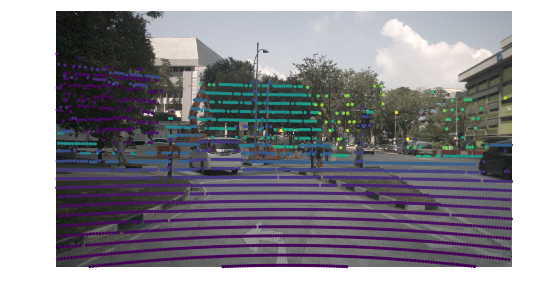

In [51]:
my_sample = nusc.sample[10]
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_TOP')

In the previous image the colors indicate the distance from the ego vehicle to each lidar point. We can also render the lidar intensity. In the following image the traffic sign ahead of us is highly reflective (yellow) and the dark vehicle on the right has low reflectivity (purple).

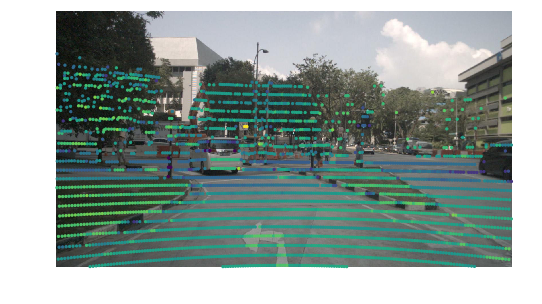

In [52]:
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_TOP', render_intensity=True)

Second, let's plot the radar point cloud for the same image. Radar is less dense than lidar, but has a much larger range.

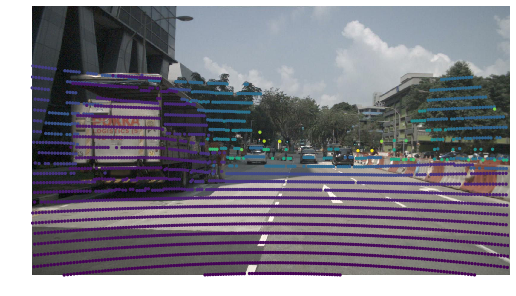

In [80]:
nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_TOP')

We can also plot all annotations across all sample data for that sample. Note how for radar we also plot the velocity vectors of moving objects. Some velocity vectors are outliers, which can be filtered using the settings in RadarPointCloud.from_file()

In [43]:
my_sample = nusc.sample[20]

# The rendering command below is commented out because it may crash in notebooks
# nusc.render_sample(my_sample['token'])

Or if we only want to render a particular sensor, we can specify that.

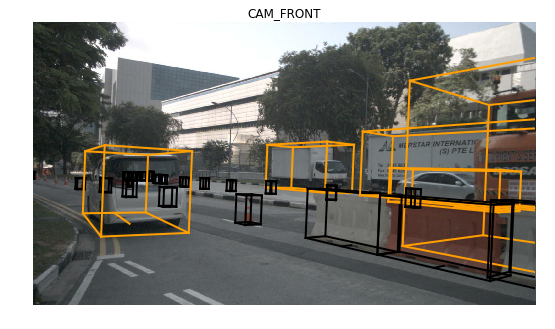

In [55]:
nusc.render_sample_data(my_sample['data']['CAM_FRONT'])

Additionally we can aggregate the point clouds from multiple sweeps to get a denser point cloud.

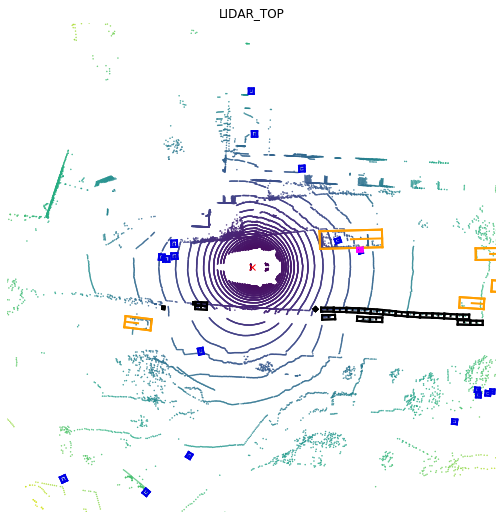

In [73]:
nusc.render_sample_data(first_sample['data']['LIDAR_TOP'], nsweeps=5, underlay_map=False)
#nusc.render_sample_data(my_sample['data']['RADAR_FRONT_RIGHT'], nsweeps=5, underlay_map=True)

We can even render a specific annotation.

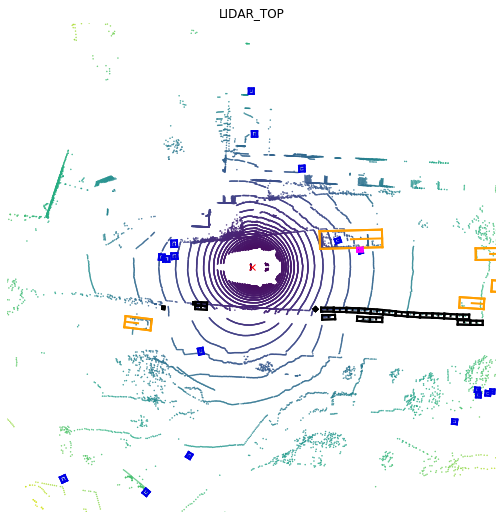

In [27]:
def nuscenes_test(sweeps=5):
    lidar_data = nusc.get('sample_data', my_sample['data']['LIDAR_TOP'])
    #pp.pprint(lidar_data['calibrated_sensor_token'])
    file_path = nuscenes_root+data_name+'/'+lidar_data['filename']
    points = LidarPointCloud.from_file(file_path)
   # pp.pprint(points.points)
#    pc.render_intensity()
    nusc.render_sample_data(my_sample['data']['LIDAR_TOP'], nsweeps=1,
                            underlay_map=False)
nuscenes_test(1)

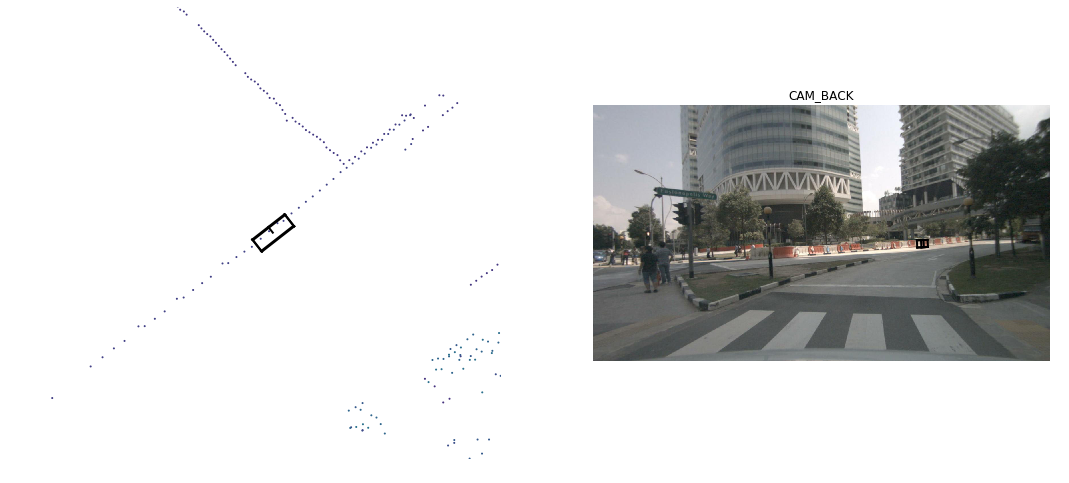

In [44]:
nusc.render_annotation(my_sample['anns'][22])